In [38]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder,LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
df = pd.read_csv('mushrooms.csv')

In [40]:
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [41]:
cap_shape = df['cap-shape'].values.reshape(-1,1)
cap_surface = df['cap-surface'].values.reshape(-1,1) 
cap_color = df['cap-color'].values.reshape(-1,1)

In [42]:
cap_shape.shape,cap_surface.shape, cap_color.shape

((8124, 1), (8124, 1), (8124, 1))

In [43]:
def preprocess():
    # Using ordinal encoder to convert the categories in the range from 0 to n-1
    cshape_enc = OrdinalEncoder()
    cshape_ = cshape_enc.fit_transform(cap_shape)

    csurface_enc = OrdinalEncoder()
    csurface_ = csurface_enc.fit_transform(cap_surface)

    ccolor_enc = OrdinalEncoder()
    ccolor_ = ccolor_enc.fit_transform(cap_color)
    # Stacking all the features
    X = np.column_stack((cshape_,csurface_,ccolor_))
    # Changing the type to int
    X = X.astype(int)
    # Doing one hot encoding on the target data
    y = df['class']
    lb = LabelBinarizer()
    y_ = lb.fit_transform(y)
    if y_.shape[1] == 1:
        y_ = np.concatenate((1 - y_, y_), axis=1)
    return X,y_,lb.classes_

In [44]:
X,y,classes = preprocess()
X.shape, y.shape

((8124, 3), (8124, 2))

In [45]:
def counts_based_onclass(X,y):
    
    # No of feature
    n_features = X.shape[1]
    # No of classes
    n_classes = y.shape[1]
    
    count_matrix = []
    # For each feature
    for i in range(n_features):
        count_feature = []
        # Get that particuar feature from the dataset
        X_feature = X[:,i]
        # For each class
        for j in range(n_classes):
            # Get the datapoints that belong to the class - j
            mask = y[:,j].astype(bool)
            # Using masking filter out the datapoints that belong to this class- j in the given feature - i
            # Using bincount -- count all the different categories present in the given feature
            counts = np.bincount(X_feature[mask])
            
            count_feature.append(counts)
            
        count_matrix.append(np.array(count_feature))
        # Finding the count of datapoints beloging to each class -- we will use it to calculate prior probabilities.
        class_count = y.sum(axis=0)
        
    return count_matrix,n_features,n_classes,class_count

In [46]:
count_matrix,n_features,n_classes,class_count = counts_based_onclass(X,y)

In [47]:
count_matrix

[array([[ 404,    0, 1596,  228,   32, 1948],
        [  48,    4, 1556,  600,    0, 1708]], dtype=int64),
 array([[1560,    0, 1144, 1504],
        [ 760,    4, 1412, 1740]], dtype=int64),
 array([[  48,   32,  624, 1032, 1264,   56,   16,   16,  720,  400],
        [ 120,   12,  876,  808, 1020,   88,    0,    0,  320,  672]],
       dtype=int64)]

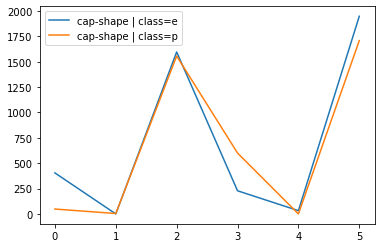

In [67]:
plt.plot(count_matrix[0][0], label="cap-shape | class=e")
plt.plot(count_matrix[0][1], label="cap-shape | class=p")
plt.legend()
plt.show()

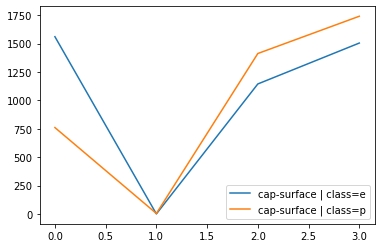

In [69]:
plt.plot(count_matrix[1][0], label="cap-surface | class=e")
plt.plot(count_matrix[1][1], label="cap-surface | class=p")
plt.legend()
plt.show()

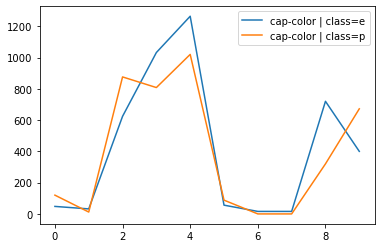

In [70]:
plt.plot(count_matrix[2][0], label="cap-color | class=e")
plt.plot(count_matrix[2][1], label="cap-color | class=p")
plt.legend()
plt.show()

In [48]:
def calculate_likelihood_probs(count_matrix,alpha,n_features):
    log_probabilities = []
    for i in range(n_features):
        num = count_matrix[i] + alpha
        den = num.sum(axis = 1).reshape(-1,1)
        log_probability = np.log(num) - np.log(den)
        log_probabilities.append(log_probability)
    return log_probabilities

In [49]:
def calculate_prior_probs(class_count):
    
    num = class_count
    den = class_count.sum()
    
    return np.log(num)-np.log(den)

In [50]:
prior_probs = calculate_prior_probs(class_count)

In [51]:
log_probs = calculate_likelihood_probs(count_matrix,1,n_features)

In [52]:
log_probs

[array([[-2.34228053, -8.34616759, -0.97028545, -2.91244559, -4.84966003,
         -0.77109589],
        [-4.38253671, -6.66491909, -0.92384083, -1.87576207, -8.27435701,
         -0.83069332]]),
 array([[-0.99261095, -8.34569287, -1.30253296, -1.0291447 ],
        [-1.63921357, -6.66440902, -1.02037655, -0.81163199]]),
 array([[-4.45529606, -4.8506088 , -1.90936471, -1.40689389, -1.20428896,
         -4.30406509, -5.51390302, -5.51390302, -1.76647722, -2.35315493],
        [-3.47958583, -5.71042702, -1.49886938, -1.57957746, -1.34683856,
         -3.78674001, -8.27537637, -8.27537637, -2.50393525, -1.76363105]])]

In [53]:
def predict(query_point,log_probs,prior_probs):
    
    # Intializing an empty array
    probs = np.zeros((1,n_classes))
    # For each feature
    for i in range(n_features):
        # Get the category_id of the feature - i from the query_point
        category = query_point[i]
        # Fetch the corresponding log_probability table and add continue to add them for all the features
        probs+=log_probs[i][:,category]
    # Finally add posterior probability
    probs+=prior_probs
    # Finding the maximum of the probabilities and fetching the corresponding class
    return classes[np.argmax(probs)]

In [57]:
from sklearn.naive_bayes import CategoricalNB
clf = CategoricalNB()
clf.fit(X, df['class'])
print('Sklearn feature log-probabilities\n',clf.feature_log_prob_)
print('Manually implemented likelihood probabilities\n',log_probs)

print('Sklearn feature prior-probabilities\n',clf.class_log_prior_)
print('Manually implemented prior probabilities\n',prior_probs)

print()
print('Sklearn predict',clf.predict(X[4:5]))
print('Manual predict',predict(X[4],log_probs,prior_probs))

Sklearn feature log-probabilities
 [array([[-2.34228053, -8.34616759, -0.97028545, -2.91244559, -4.84966003,
        -0.77109589],
       [-4.38253671, -6.66491909, -0.92384083, -1.87576207, -8.27435701,
        -0.83069332]]), array([[-0.99261095, -8.34569287, -1.30253296, -1.0291447 ],
       [-1.63921357, -6.66440902, -1.02037655, -0.81163199]]), array([[-4.45529606, -4.8506088 , -1.90936471, -1.40689389, -1.20428896,
        -4.30406509, -5.51390302, -5.51390302, -1.76647722, -2.35315493],
       [-3.47958583, -5.71042702, -1.49886938, -1.57957746, -1.34683856,
        -3.78674001, -8.27537637, -8.27537637, -2.50393525, -1.76363105]])]
Manually implemented likelihood probabilities
 [array([[-2.34228053, -8.34616759, -0.97028545, -2.91244559, -4.84966003,
        -0.77109589],
       [-4.38253671, -6.66491909, -0.92384083, -1.87576207, -8.27435701,
        -0.83069332]]), array([[-0.99261095, -8.34569287, -1.30253296, -1.0291447 ],
       [-1.63921357, -6.66440902, -1.02037655, -0.8

ValueError: could not broadcast input array from shape (2,6) into shape (2)

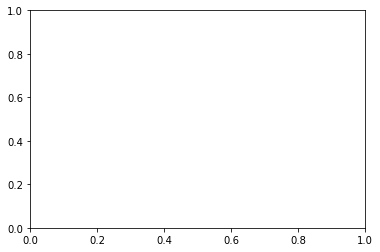